In [120]:
import os
import nd2
import pickle
import napari
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
import colorcet as cc

In [2]:
path_dir = r'D:\data_analysis\2022_Sahana\data\Collagen\60x images'
im_name = r'092622_ring_PDMSAp_10MCol_647-Act_561-Pax_488-Plak_DAPI_001.nd2'
path_im = os.path.join(path_dir,im_name)

path_vertices = r'D:\data_analysis\2022_Sahana\masks'

path_results = r'D:\data_analysis\2022_Sahana\results'
path_df = os.path.join(path_results,im_name.replace('.nd2','_df.pkl'))

# order of channels
    # actin
    # paxilin
    # plakoglobin
    # DAPI


## Read in the image, annotations and the data frame

In [3]:
# read in image
im = nd2.imread(path_im)
im.shape

(27, 4, 512, 512)

In [6]:
# read in polygons and masks

pkl_path = os.path.join(path_vertices,im_name.replace('.nd2','_polygons.pkl'))

with open(pkl_path, 'rb') as f:
    vertices_polygons = pickle.load(f)

mask_path = os.path.join(path_vertices,im_name.replace('.nd2','_mask.png'))
mask = imread(mask_path)

In [156]:
df = pd.read_pickle(path_df)

In [157]:
df.columns

Index(['label', 'area', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1',
       'bbox-2', 'bbox-3', 'eccentricity', 'orientation', 'intensity_image',
       'image', 'image_name', 'vertices', 'membrane_orientation',
       'actin_detected', 'actin_angles', 'actin_orientation', 'actin_spread',
       'plak_signal'],
      dtype='object')

## Visualize orientation of cell edge

In [285]:
cell = df.loc[1,:]
vertices = (cell.vertices - np.array([cell['bbox-0'],cell['bbox-1']])).astype(int)
orientations = (np.array(cell.membrane_orientation) + np.pi/2)/np.pi
color = cc.cm.colorwheel(orientations)

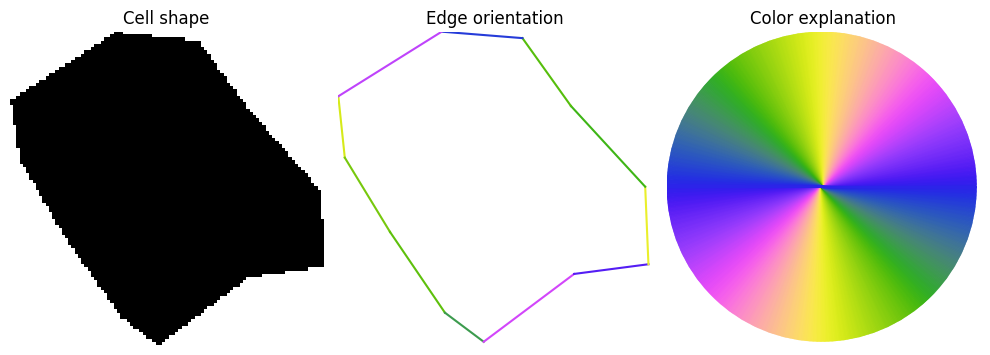

In [288]:
fig,axes = plt.subplots(1,3,figsize=(10,6))

axes[0].imshow(cell.image,cmap=cm.gray_r)
axes[0].set_title('Cell shape')

############################################################################################
axes[1].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[1].set_title('Edge orientation')

for i in range(len(vertices)):
    
    p0 = vertices[i]

    if (i == (len(vertices)-1)):
        p1 = vertices[0]
    else:
        p1 = vertices[i+1]
    
    axes[1].plot((p0[1], p1[1]), (p0[0], p1[0]),c = color[i])


axes[1].set_xlim((0, cell.image.shape[1]))
axes[1].set_ylim((cell.image.shape[0], 0))

############################################################################################
axes[2].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[2].set_title('Color explanation')

im_center = (int(cell.image.shape[0]/2), (int(cell.image.shape[1]/2)))
patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[2].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle)

    t = axes[2].axline(im_center, slope=slope,c=cc.cm.colorwheel(angle/(np.pi)))
    t.set_clip_path(patch)


axes[2].set_xlim((0, cell.image.shape[1]))
axes[2].set_ylim((cell.image.shape[0], 0))

############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Visualize actin orientation

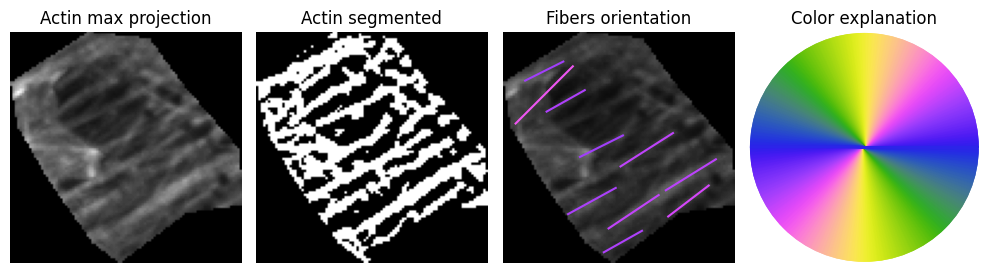

In [287]:
fig,axes = plt.subplots(1,4,figsize=(10,6))

############################################################################################
actin_image = cell.intensity_image[:,:,0]
axes[0].imshow(actin_image,cmap=cm.gray)
axes[0].set_title('Actin max projection')
############################################################################################
axes[1].imshow(cell.intensity_image[:,:,4],cmap=cm.gray)
axes[1].set_title('Actin segmented')

############################################################################################
axes[2].imshow(actin_image,cmap=cm.gray,vmax=np.max(actin_image)*1.5)
axes[2].set_title('Fibers orientation')

for line,angle in zip(cell.actin_detected,cell.actin_angles):

    p0,p1 = line
    axes[2].plot((p0[0], p1[0]), (p0[1], p1[1]),c = cc.cm.colorwheel((angle+np.pi/2)/(np.pi)))

############################################################################################

axes[3].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[3].set_title('Color explanation')

im_center = (int(cell.image.shape[0]/2), (int(cell.image.shape[1]/2)))
patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[3].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle)

    t = axes[3].axline(im_center, slope=slope,c=cc.cm.colorwheel(angle/(np.pi)))
    t.set_clip_path(patch)


############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Edge orientation vs main flow of actin

In [270]:
def calculate_perpendicular_index(angle_actin,angle_membrane):
    
    orientation = np.abs(np.abs(np.abs(angle_membrane - angle_actin) - (np.pi/2))/(np.pi/2)-1)

    return orientation

orientations = []
for angle_membrane in cell.membrane_orientation:

    orientation = calculate_perpendicular_index(cell.actin_orientation,angle_membrane)

    orientations.append(orientation)

orientations

[0.7363070683606284,
 0.9786141117563134,
 0.9669388386469753,
 0.771135536106218,
 0.05301830749186609,
 0.2683864240109526,
 0.6729416754943418,
 0.8990258311762933,
 0.952376646174892,
 0.42411895976426406,
 0.010284639824672426]

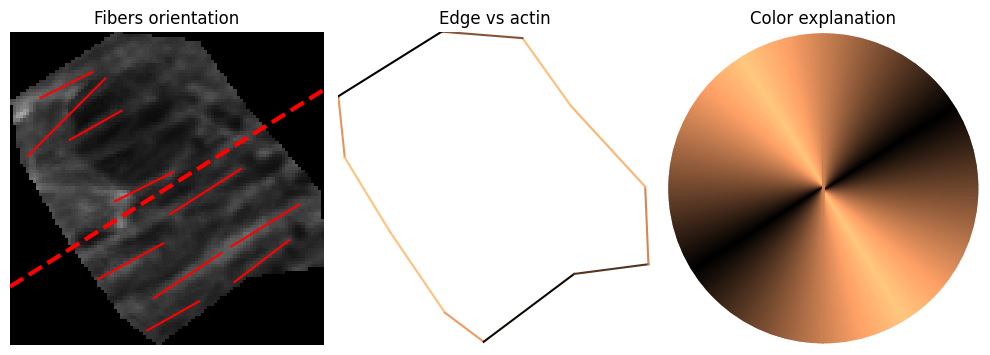

In [275]:
fig,axes = plt.subplots(1,3,figsize=(10,6))

color = cm.copper(orientations)

############################################################################################
actin_image = cell.intensity_image[:,:,0]
axes[0].imshow(actin_image,cmap=cm.gray,vmax=np.max(actin_image)*1.5)
axes[0].set_title('Fibers orientation')

for line,angle in zip(cell.actin_detected,cell.actin_angles):

    p0,p1 = line
    axes[0].plot((p0[0], p1[0]), (p0[1], p1[1]),c = 'red')

axes[0].axline(im_center, slope=-np.tan(cell.actin_orientation+np.pi/2),c='red',linewidth=3,linestyle='--')
############################################################################################
axes[1].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[1].set_title('Edge vs actin')

for i in range(len(vertices)):
    
    p0 = vertices[i]

    if (i == (len(vertices)-1)):
        p1 = vertices[0]
    else:
        p1 = vertices[i+1]
    
    axes[1].plot((p0[1], p1[1]), (p0[0], p1[0]),c = color[i])



axes[1].set_xlim((0, cell.image.shape[1]))
axes[1].set_ylim((cell.image.shape[0], 0))

############################################################################################

axes[2].imshow(np.ones(cell.image.shape),cmap=cm.gray_r)
axes[2].set_title('Color explanation')

im_center = (int(cell.image.shape[0]/2), (int(cell.image.shape[1]/2)))
patch = patches.Circle(im_center, radius=int(np.min(cell.image.shape)/2), transform=axes[2].transData)

for angle in np.linspace(0,np.pi,360):

    slope = -np.tan(angle-np.pi/2)
    orientation = calculate_perpendicular_index(cell.actin_orientation,angle)

    t = axes[2].axline(im_center, slope=slope,c=cm.copper(orientation))
    t.set_clip_path(patch)


############################################################################################
for a in axes:
    a.set_axis_off()

plt.tight_layout()
plt.show()